# Polygon drill

**What does this notebook do?** 

This notebook pulls in data based on the extent of a provided polygon. The polygon is then used to mask the data. 

A shape file containing the polygon you would like to use for the analysis is requied. Here we use the ACT state boundary, available as a [shapefile from data.gov.au](https://data.gov.au/dataset/act-state-boundary-psma-administrative-boundaries/resource/20cc8694-1ac0-4c5c-bc5f-7710089d824a). This shapefile has been downloaded for you and included in the CSIRO EASI training repostiory in the `work/extras/ACT_state_polygon` directory. In the notebook this is available as `/home/jovyan/work/extras/ACT_state_polygon`. If you would like to use a different shapefile you can copy into the work directory on your docker host and it will be available to the notebook under `/home/jovyan/work/<where you put it>`

This notebook is adapted from a Digital Earth Australia example by Claire Krause

In [1]:
%matplotlib inline

from datacube import Datacube
from datacube.storage import masking
from datacube.utils import geometry
import fiona
import rasterio.features

# Import the custom script for plotting. This script can be found in the dea-notebooks repository.
import sys
import os.path

dc = Datacube(app = 'Polygon drill')

/home/jovyan/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## Import our shapefile with Fiona, and grab its `geometry` for the ODC load() 

<xarray.Dataset>
Dimensions:  (time: 1, x: 2054, y: 2893)
Coordinates:
  * time     (time) datetime64[ns] 2018-04-16T23:49:35.616007
  * y        (y) float64 -3.94e+06 -3.94e+06 -3.94e+06 -3.94e+06 -3.94e+06 ...
  * x        (x) float64 1.513e+06 1.513e+06 1.513e+06 1.513e+06 1.513e+06 ...
Data variables:
    swir1    (time, y, x) float64 1.058e+03 610.0 233.0 110.0 99.0 92.0 97.0 ...
    nir      (time, y, x) float64 1.38e+03 1.128e+03 345.0 304.0 258.0 227.0 ...
    green    (time, y, x) float64 238.0 187.0 81.0 52.0 50.0 51.0 50.0 56.0 ...
Attributes:
    crs:      EPSG:3577


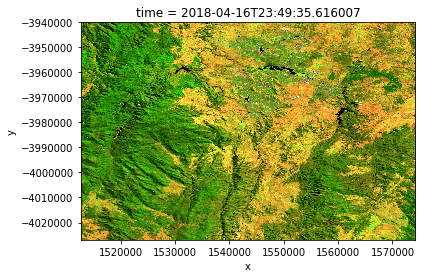

In [2]:
# Set this to the location you have saved your ACT boundary polygon
shape_file = os.path.expanduser('~/work/extras/ACT_state_polygon/ACT_STATE_POLYGON_shp.shp')

with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

query = {'geopolygon': geom,
         'time': ('2018-04-15', '2018-04-20'),
         'output_crs': 'EPSG:3577',
         'resolution': (-30, 30)}

data = dc.load(product='ls8_usgs_sr_scene', measurements=['swir1', 'nir', 'green'], group_by='solar_day', **query)

# Clean up invalid data
# Set all nodata pixels to `NaN` for the data variables
filtered_nans = masking.mask_invalid_data(data)
# Set all invalid to `NaN` - valid range for USRS SR is 0 to 10000
filtered_nans = filtered_nans.where((filtered_nans >= 0) & (filtered_nans<=10000))

data.update(filtered_nans)
filtered_nans = None # clean up memory

print(data)
data[['swir1','nir','green']].isel(time = 0).to_array().plot.imshow(robust=True)



Although we have used a polygon for our import, the extent of the returned data is a rectangle with the extents set by the input polygon, not a dataset with areas outside of the polygon set to `NaN`. In this instance, we only want to deal with data inside of our polygon, so we will use it to mask the returned dataset.


## Mask the dataset with our original polygon to remove extra data

This code creates a mask from the polygons in the input shapefile

In [3]:
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs) for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
dataMasked = data.where(mask)

## Check our polygon has been imported properly

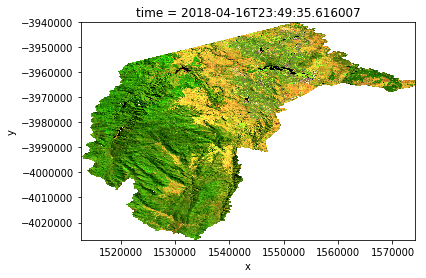

In [4]:
dataMasked[['swir1','nir','green']].isel(time = 0).to_array().plot.imshow(robust=True)
